In [1]:
from helpers.charting_tools import Charting
from helpers.data_processing import add_ti
from BookWorm import BookWorm, BinanceWrapper
from PIL import Image

In [2]:
worm = BookWorm()

In [79]:
candles = worm.historical_candles(start_time='January 1 2019', end_time='February 1 2019', api_wrapper=BinanceWrapper('5lJ0uGit9PuUxHka3hBWhPmsi7dWyxEwvEntUZFKmm0xfNz3VjHWi5WSr5W1VBJV',
                                                      'BFWVs8ko7Cd4sjdQ9amGJTnToGWy9TbQWIjeorSCj23FGiwFaknzkgLPcrgWrxsw'), 
                  symbol='ETHBTC', interval='1m')

In [80]:
candles = add_ti(candles)

In [81]:
def split_candles(df, num_rows=30, step=10):
    """Split a DataFrame of candlestick data into a list of smaller DataFrames each with num_rows rows"""
    
    slices = []
    
    for row_i in range(0, df.shape[0] - num_rows, step):
        small_df = df.iloc[row_i:row_i+num_rows, :]
        slices.append(small_df)
        
    return slices

In [82]:
def price_returns(df, num_rows=30, num_into_fut=5, step=10):
    labels = []
    
    for row_i in range(0, df.shape[0] - num_rows - num_into_fut, step):
        # skip all iterations while row_i < num_rows since nothing yet to create a label for
        if row_i <= num_rows: continue
        
        vf, vi = df['close'][row_i+num_into_fut], df['close'][row_i]
        price_return = (vf - vi) / vi
        labels.append(price_return)
    return labels

In [83]:
# split candles into 30 period and a label
candles_sliced = split_candles(candles)
labels_candles_sliced = price_returns(candles)
# we need to remove candle slices without a label from candles_sliced
candles_sliced = candles_sliced[len(candles_sliced)-len(labels_candles_sliced):]

assert len(candles_sliced) == len(labels_candles_sliced)
len(candles_sliced)

4455

In [ ]:
def create_charts(candles_sliced, save_path):
    """Create a chart image for each in sliced_candles and return a list of paths to those images"""
    from tqdm import tqdm_notebook as tqdm
    import warnings
    warnings.filterwarnings("ignore")
    
    i = 0
    paths_to_images = []
    for small_df in tqdm(candles_sliced):
        chart = Charting(small_df, 'time', 'close')
        
        path = save_path + 'chart_{}.png'.format(i)
        chart.chart_to_image(path)
        paths_to_images.append(path)
        i += 1
    return paths_to_images        

In [ ]:
paths_to_images = create_charts(candles_sliced, "images/")

In [84]:
paths_to_images = [ 'images/chart_{}.png'.format(i) for i in range(len(candles_sliced)) ]

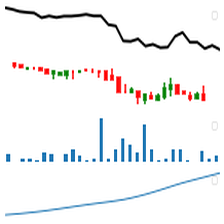

In [85]:
Image.open(paths_to_images[100])

In [62]:
def normalize_series(ser):
    return (ser-ser.min())/(ser.max()-ser.min())

In [63]:
try: candles = candles.drop('time', axis=1)
except: pass
candles.shape

(566841, 11)

In [64]:
candles.apply(normalize_series, axis=0)

,open,high,low,close,volume,sma20,macd,obv,bb20_low,bb20_mid,bb20_up
24,0.294695,0.294816,0.295438,0.294691,0.007892,0.297465,1.000000,0.724619,0.298127,0.297465,0.294494
25,0.294988,0.294634,0.294983,0.294267,0.010340,0.297578,0.957259,0.724342,0.298357,0.297578,0.294490
26,0.294766,0.294846,0.293143,0.294024,0.016392,0.297686,0.917540,0.723903,0.298665,0.297686,0.294401
27,0.293887,0.293807,0.292859,0.293479,0.007877,0.297774,0.880663,0.723693,0.298952,0.297774,0.294294
28,0.293281,0.293565,0.293355,0.293479,0.010889,0.297817,0.846456,0.723693,0.299108,0.297817,0.294225
29,0.293271,0.294181,0.293699,0.293772,0.011751,0.297832,0.814750,0.724007,0.299157,0.297832,0.294206
30,0.293786,0.294382,0.294073,0.294034,0.017002,0.297848,0.785378,0.724462,0.299204,0.297848,0.294193
31,0.294604,0.294645,0.294781,0.294701,0.008270,0.297926,0.758183,0.724683,0.299497,0.297926,0.294060
32,0.294695,0.294826,0.294821,0.294620,0.015599,0.298031,0.733012,0.724266,0.299850,0.298031,0.293920
33,0.294634,0.294463,0.293527,0.293984,0.018777,0.298077,0.709726,0.723763,0.299970,0.298077,0.293893


In [86]:
import torch
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 5}

In [87]:
from helpers.datasets import DFTimeSeriesDataset, ChartImageDataset
from torch.utils.data import *
# create dataloaders
# specify the split between train_df and valid_df from the process of splitting dataset_windows 
split = 0.7

s = int(len(candles_sliced) * 0.7)
while s % params['batch_size'] != 0:
    s += 1

# create two ChartImageDatasets, split by split, for the purpose of creating a DataLoader for the specific model
train_ds_cnn = ChartImageDataset(paths_to_images[:s], labels_candles_sliced[:s])
valid_ds_cnn = ChartImageDataset(paths_to_images[s:], labels_candles_sliced[s:])
train_gen_cnn = DataLoader(train_ds_cnn, **params)
valid_gen_cnn = DataLoader(valid_ds_cnn, **params)

In [88]:
def _train(train_gen, model, optim, error_func):
    losses = []
    
    for batch, labels in train_gen:
        batch, labels = batch.cuda().float(), labels.cuda().float()
        # set model to train mode
        model.train()
        
        # clear gradients
        model.zero_grad()
        
        output = model(batch)
        loss = error_func(output, labels)
        loss.backward()
        optim.step()
        
        
        losses.append(loss)
        
    return round(float(sum(losses) / len(losses)), 6)

In [89]:
def _valid(valid_gen, model, optim, error_func):
    with torch.set_grad_enabled(False):
        losses = []

        for batch, labels in valid_gen:
            batch, labels = batch.cuda().float(), labels.cuda().float()
            
            # set to eval mode
            model.eval()
            
            # clear gradients
            model.zero_grad()

            output = model(batch)
            loss = error_func(output, labels)

            losses.append(loss)
        
    return round(float(sum(losses) / len(losses)), 6)

In [90]:
def _test(test_gen, model, optim, error_func):
    with torch.set_grad_enabled(False):
        losses = []

        for batch, labels in valid_gen:
            batch, labels = batch.cuda().float(), labels.cuda().float()
            
            # set to eval mode
            model.eval()
            
            # clear gradients
            model.zero_grad()

            output = model(batch)
            loss = error_func(output, labels)

            losses.append(loss)
        
    return round(float(sum(losses) / len(losses)), 6)

In [91]:
def train(model, model_name, optim, num_epochs, train_gen, valid_gen, test_gen=None):
    """Train a PyTorch model with optim as optimizer strategy"""
    
    for epoch_i in range(num_epochs):
        
        
        def RMSE(x, y):
            
            # have to squish x into a rank 1 tensor with batch_size length with the outputs we want
            if model_name == 'resnet':
                 # torch.Size([64, 1])
                x = x.squeeze(1)
            elif model_name == 'gru':
                # torch.Size([64, 30, 1])
                x = x[:, 29, :] # take only the last prediction from the 30 time periods in our matrix
                x = x.squeeze(1)
            mse = torch.nn.MSELoss()
            return torch.sqrt(mse(x, y))
        
        
        # forward and backward passes of all batches inside train_gen
        train_loss = _train(train_gen, model, optim, RMSE)
        valid_loss = _valid(valid_gen, model, optim, RMSE)
        
        # run on test set if provided
        if test_gen: test_output = _test(test_gen, model, optim)
        else: test_output = "no test selected"
        print("train loss: {}, valid loss: {}, test output: {}".format(train_loss, valid_loss, test_output))

In [92]:
from models.CNN.CNN import CNN
cnn = CNN().cuda().float()

In [93]:
train(cnn, 'resnet', torch.optim.Adam(cnn.parameters(), 1e-3), 15, train_gen_cnn, valid_gen_cnn)

train loss: 0.036602, valid loss: 0.008366, test output: no test selected
train loss: 0.011465, valid loss: 0.008114, test output: no test selected
train loss: 0.019907, valid loss: 0.007244, test output: no test selected
train loss: 0.007044, valid loss: 0.009044, test output: no test selected
train loss: 0.004957, valid loss: 0.002753, test output: no test selected
train loss: 0.011349, valid loss: 0.023379, test output: no test selected
train loss: 0.01012, valid loss: 0.010273, test output: no test selected
train loss: 0.006491, valid loss: 0.004303, test output: no test selected
train loss: 0.005484, valid loss: 0.002646, test output: no test selected
train loss: 0.01114, valid loss: 0.001206, test output: no test selected
train loss: 0.004712, valid loss: 0.003009, test output: no test selected
train loss: 0.004943, valid loss: 0.005468, test output: no test selected
train loss: 0.004107, valid loss: 0.005567, test output: no test selected
train loss: 0.003993, valid loss: 0.0015

In [76]:
from models.GRU.GRU import GRUnet
gru = GRUnet(num_features=12, num_rows=30, batch_size=64, hidden_size=500).cuda().float()

In [77]:
from helpers.datasets import DFTimeSeriesDataset, ChartImageDataset
from torch.utils.data import *
# create dataloaders
# specify the split between train_df and valid_df from the process of splitting dataset_windows 
split = 0.7

s = int(len(candles_sliced) * 0.7)
while s % params['batch_size'] != 0:
    s += 1

# create two ChartImageDatasets, split by split, for the purpose of creating a DataLoader for the specific model
train_ds_gru = DFTimeSeriesDataset(candles_sliced[:s], labels_candles_sliced[:s])
valid_ds_gru = DFTimeSeriesDataset(candles_sliced[s:], labels_candles_sliced[s:])
train_gen_gru = DataLoader(train_ds_gru, **params)
valid_gen_gru = DataLoader(valid_ds_gru, **params)

In [78]:
train(gru, 'gru', torch.optim.Adam(gru.parameters(), 1e-3), 50, train_gen_gru, valid_gen_gru)

train loss: 0.005793, valid loss: 0.001791, test output: no test selected
train loss: 0.002739, valid loss: 0.001856, test output: no test selected
train loss: 0.002253, valid loss: 0.00184, test output: no test selected
train loss: 0.002145, valid loss: 0.00184, test output: no test selected
train loss: 0.002133, valid loss: 0.001767, test output: no test selected
train loss: 0.002064, valid loss: 0.001802, test output: no test selected
train loss: 0.002034, valid loss: 0.00172, test output: no test selected
train loss: 0.002014, valid loss: 0.001683, test output: no test selected
train loss: 0.002039, valid loss: 0.001656, test output: no test selected
train loss: 0.002033, valid loss: 0.001691, test output: no test selected
train loss: 0.002, valid loss: 0.001828, test output: no test selected
train loss: 0.00199, valid loss: 0.001708, test output: no test selected
train loss: 0.001977, valid loss: 0.001685, test output: no test selected
train loss: 0.001978, valid loss: 0.001715, t